# 2. Improving quality of classification models

### 2.1. Взвешивание классов
Придадим объектам редкого класса больший вес.

Алгоритмы машинного обучения считают все объекты обучающей выборки равнозначными по умолчанию. Если важно указать, что какие-то объекты важнее, их классу присваивается вес (англ. class_weight, «вес класса»).

В алгоритме логистической регрессии в библиотеке `sklearn` есть аргумент `class_weight`. По умолчанию он равен `None`, т. е. классы равнозначны:

Если указать `class_weight='balanced'` (англ. «сбалансированный»), алгоритм посчитает, во сколько раз класс `«0»` встречается чаще класса `«1»` Обозначим это число `N` (неизвестное количество раз). Новые веса классов выглядят так:

`вес класса «0» = 1.0`
`вес класса «1» = N`

Бóльший вес будет у редкого класса.
Аргумент `class_weight` также есть у решающего дерева и случайного леса.

In [1]:
import pandas as pd
from numpy.random.mtrand import random
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


data = pd.read_csv(r'E:\COURSES\Кодинг\[Yandex praxis]. DS specialist + (2022)\6\Часть 6\04 Несбалансированная классификация\travel_insurance_preprocessed.csv')
target = data['Claim']
features = data.drop('Claim', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.08698830409356725


### 2.2. Upsampling
Когда обучают модели, такая техника называется `upsampling`. Это делается в несколько этапов:


* 2.2.1. Разделить обучающую выборку на отрицательные и положительные объекты;
* 2.2.2. Скопировать несколько раз положительные объекты;
* 2.2.3. С учётом полученных данных создать новую обучающую выборку;
* 2.2.4. Перемешать данные: идущие друг за другом одинаковые вопросы не помогут обучению.

Пример:
*  `features_zeros` = 0
*  `features_ones` = 1
*  `target_zeros` = 0
*  `target_ones` = 1

In [2]:
#2.2.2 - 2.2.4
from sklearn.utils import shuffle
def upsample(features, target, repeat):
    # skimming 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    #upsample
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    #shuffle
    features_upsampled = shuffle(features_upsampled, random_state = 12345)
    target_upsampled = shuffle(target_upsampled, random_state = 12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
print(features_upsampled.shape)
print(target_upsampled.shape)

(43251, 196)
(43251,)


Let's try to find new F1 for the upsampled model

In [3]:
from sklearn.metrics import recall_score, precision_score, f1_score

features_upsampled_train, features_upsampled_valid, target_upsampled_train, target_upsampled_valid = train_test_split(
    features_upsampled, target_upsampled, test_size=0.25, random_state=12345)

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_upsampled_train, target_upsampled_train)
predicted_upsampled_valid = model.predict(features_upsampled_valid)

print("F1:", f1_score(target_upsampled_valid, predicted_upsampled_valid))

precision_score = precision_score(target_upsampled_valid, predicted_upsampled_valid)
print(precision_score)

recall_score = recall_score(target_upsampled_valid, predicted_upsampled_valid)
print(recall_score)

F1: 0.5145696860176192
0.3838894506235254
0.7801369863013699


### 2.3. Downsampling


In [4]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state =12345)]+[features_ones]) # .sample is used to randomly sampled trow from this DF
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state =12345)]+[target_ones])
    #shuffle
    features_downsampled = shuffle(features_downsampled, random_state = 12345)
    target_downsampled = shuffle(target_downsampled, random_state = 12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

features_downsampled_train, features_downsampled_valid, target_downsampled_train, target_downsampled_valid = train_test_split(
    features_downsampled, target_downsampled, test_size=0.25, random_state=12345)


model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_downsampled_train, target_downsampled_train)
predicted_downsampled_valid = model.predict(features_downsampled_valid)

print("F1:", f1_score(target_downsampled_valid, predicted_downsampled_valid))

precision_score = precision_score(target_downsampled_valid, predicted_downsampled_valid)
print(precision_score)

recall_score = recall_score(target_downsampled_valid, predicted_downsampled_valid)
print(recall_score)

F1: 0.5080091533180778
0.3908450704225352
0.7254901960784313


### 2.4. Predict probabilities

Чтобы определить ответ, логистическая регрессия вычисляет, к какому классу близок объект, затем сравнивает результат с нулём.
Для удобства близость к классам переведём в вероятность классов: модель пытается оценить, насколько вероятен тот или иной класс.

У нас всего два класса (ноль и единица). Нам достаточно вероятности класса «1». Число будет от нуля до единицы: если больше 0.5 — объект положительный, меньше — отрицательный.


Граница, где заканчивается отрицательный класс и начинается положительный, называется `порогом` (англ. `threshold`). По умолчанию он равен 0.5, но что если его поменять?

В библиотеке `sklearn` вероятность классов вычисляет функция `.predict_proba()` (от англ. predict probabilities, «предсказать вероятности»). На вход она получает признаки объектов, а возвращает вероятности:

Строки соответствуют объектам. В первом столбце указана вероятность отрицательного класса, а во втором — положительного (сумма вероятностей равна единице). Выведем их на экран.



In [5]:
probabilities_valid = model.predict_proba(features_downsampled_valid)
probabilities_one_valid = probabilities_valid[:,1] # взять все строки и второй столбец - положительный, класс "1"; верояность числа 1.
# Таким образом, probabilities_one_valid будет содержать вероятности того, что соответствующие образцы принадлежат к классу «1». Это можно интерпретировать как вероятность правильного предположения о принадлежности к классу «1» для каждого образца в вашем валидационном наборе данных.

In [6]:
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np
for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = ((model
                        .predict_proba(
        features_downsampled_valid)[:, 1]
                        > threshold)
                       .astype(int))
    precision = precision_score(target_downsampled_valid, predicted_valid)
    recall = recall_score(target_downsampled_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.141, Полнота = 1.000
Порог = 0.02 | Точность = 0.141, Полнота = 1.000
Порог = 0.04 | Точность = 0.141, Полнота = 0.987
Порог = 0.06 | Точность = 0.149, Полнота = 0.980
Порог = 0.08 | Точность = 0.159, Полнота = 0.974
Порог = 0.10 | Точность = 0.169, Полнота = 0.967
Порог = 0.12 | Точность = 0.177, Полнота = 0.948
Порог = 0.14 | Точность = 0.187, Полнота = 0.941
Порог = 0.16 | Точность = 0.197, Полнота = 0.935
Порог = 0.18 | Точность = 0.207, Полнота = 0.908
Порог = 0.20 | Точность = 0.216, Полнота = 0.908
Порог = 0.22 | Точность = 0.224, Полнота = 0.889
Порог = 0.24 | Точность = 0.232, Полнота = 0.850
Порог = 0.26 | Точность = 0.249, Полнота = 0.843
Порог = 0.28 | Точность = 0.253, Полнота = 0.830


### 2.5. PR-кривая

PR-кривой (от англ. Precision и Recall). Чем выше кривая, тем лучше модель

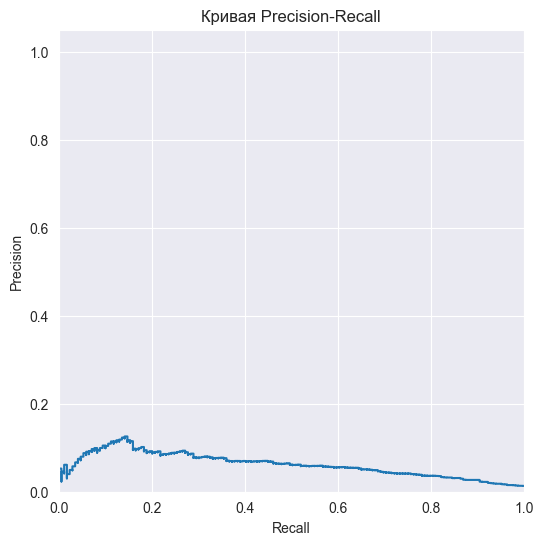

In [7]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

### 2.6. TPR и FPR

Когда положительных объектов нет, точность не вычислить. Выберем другие характеристики, в которых нет деления на ноль.

Как измерить, насколько правильно классификатор находит объекты? Долей верно предсказанных объектов к общему числу объектов класса. Это отношение называется
TPR (англ. `True Positive Rate`) или «полнота», а на английском используют термин recall. Формула выглядит так, где

P=TP+FN

$$
TPR = \frac{TP}{TP+FN}
$$
Доля ложных срабатываний к общему числу объектов за пределами класса (англ. `False Positive Rate`, FPR) вычисляется аналогично. Это отношение FP-ответов (англ. False Positives — отрицательные, классифицированные как положительные) к сумме отрицательных ответов:
TN (англ. True Negatives — верно классифицированные отрицательные ответы). Ниже дана формула, где
N=FP+TN:

$$
FPR = \frac{FP}{FP+TN}
$$

### 2.7. ROC-curve
Мы стали свидетелями нового противостояния — `TPR` против `FPR`. Изобразим его на графике.
По горизонтали нанесём долю ложноположительных ответов (`FPR`), а по вертикали — долю истинно положительных ответов (`TPR`). Переберём значения порога логистической регрессии и проведём кривую. Она называется ROC-кривая, или кривая ошибок (от англ. `receiver operating characteristic`, «характеристика работы приёмника»; термин пришёл из теории обработки сигналов).
Для модели, которая всегда отвечает случайно, ROC-кривая выглядит как прямая, идущая из левого нижнего угла в верхний правый. Чем график выше, тем больше значение TPR и лучше качество модели.

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под `ROC-кривой` — `AUC-ROC` (от англ. `Area Under Curve ROC`, «площадь под `ROC-кривой`»). Это новая метрика качества, которая изменяется от 0 до 1. `AUC-ROC` случайной модели равна 0.5.

Построить `ROC-кривую` поможет функция `roc_curve() (англ. ROC-кривая)` из модуля `sklearn.metrics`:

На вход она принимает значения целевого признака и вероятности положительного класса. Перебирает разные пороги и возвращает три списка: значения `FPR`, значения `TPR` и рассмотренные пороги.
`fpr, tpr, thresholds = roc_curve(target, probabilities)`


Постройте ROC-кривую для логистической регрессии и изобразите её на графике. Вам поможет инструкция в коде.
Для удобства мы уже добавили в код график ROC-кривой случайной модели.


<Figure size 640x480 with 0 Axes>

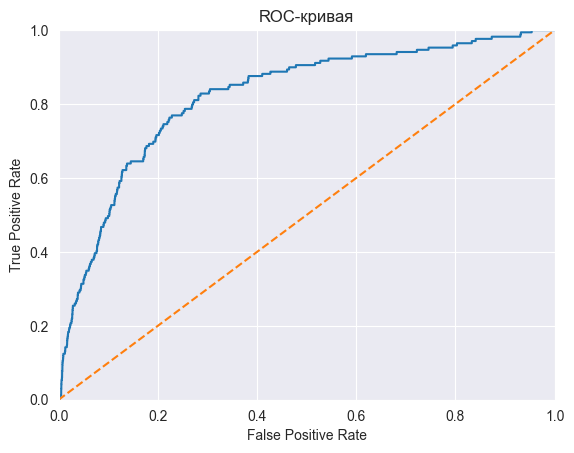

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
data = pd.read_csv(r'E:\COURSES\Кодинг\[Yandex praxis]. DS specialist + (2022)\6\Часть 6\04 Несбалансированная классификация\travel_insurance_preprocessed.csv')
target = data['Claim']
features = data.drop('Claim', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.25, random_state=12345)
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8222588624809644
